In [1]:
import os
import dicom2nifti
from PIL import Image
import glob
from utils import Create_Folder,RescaleIntensity,resampleImage_img_2D,get_max_roi_3d,reshape_transform
import torch
import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import Activations, EnsureChannelFirst, AsDiscrete, Compose, LoadImage, SaveImage, ScaleIntensity,EnsureChannelFirst,ScaleIntensity
import shutil
import numpy as np
import SimpleITK as sitk
import torch
import numpy as np
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, \
                                         deprocess_image, \
                                         preprocess_image
import cv2 
%matplotlib inline


In [2]:
dicom_folder = "Dicom_data"   # the dicom data
nii_folder = 'results\\nii_data'  #Store the 3d volumes after conversion
PNG_save_folder = 'results\\PNG_data'  #Store the 2d slices after conversion 
PNG_label_folder = 'results\\PNG_label_data' #temporary files
PredSegmentation_folder = 'results\\PredSegmentation_data'#Store the 2d pred segmentation 
Save_basename = "results\\top_three_slices" #Store the top three slices coontaining the ST for classification task 

Data Processing(Dicom2nii,RescaleIntensity,nii2PNG)

In [3]:
if os.path.exists(nii_folder):
    shutil.rmtree(nii_folder)
os.makedirs(nii_folder)# Create folder to store the .nii files
dicom2nifti.convert_directory(dicom_folder, nii_folder, compression= True,reorient=False) #Default compression= True,reorient=True
nii_path  = glob.glob(nii_folder+'/*.nii.gz')
img = sitk.ReadImage(nii_path[0])
img.SetDirection((1,0,0,0,1,0,0,0,1))  # RAI
img_resmaple = resampleImage_img_2D(img,[0.35,0.35])
Rescale_img= RescaleIntensity(img_resmaple)

img_array = sitk.GetArrayFromImage(Rescale_img)
Create_Folder([PNG_save_folder])
for i in range(img_array.shape[0]):
        img_save_path = os.path.join(PNG_save_folder,f"PNG_{i}.png")
        img_png = Image.fromarray(np.uint8(img_array[i]))
        img_png.save(img_save_path)  


2023-05-27 20:54:55,557 - Organizing: Dicom_data\FILE (1).dcm
2023-05-27 20:54:55,559 - Organizing: Dicom_data\FILE(10).dcm
2023-05-27 20:54:55,562 - Organizing: Dicom_data\FILE(11).dcm
2023-05-27 20:54:55,565 - Organizing: Dicom_data\FILE(12).dcm
2023-05-27 20:54:55,568 - Organizing: Dicom_data\FILE(13).dcm
2023-05-27 20:54:55,572 - Organizing: Dicom_data\FILE(14).dcm
2023-05-27 20:54:55,577 - Organizing: Dicom_data\FILE(15).dcm
2023-05-27 20:54:55,580 - Organizing: Dicom_data\FILE(16).dcm
2023-05-27 20:54:55,583 - Organizing: Dicom_data\FILE(17).dcm
2023-05-27 20:54:55,586 - Organizing: Dicom_data\FILE(18).dcm
2023-05-27 20:54:55,588 - Organizing: Dicom_data\FILE(2).dcm
2023-05-27 20:54:55,591 - Organizing: Dicom_data\FILE(3).dcm
2023-05-27 20:54:55,593 - Organizing: Dicom_data\FILE(4).dcm
2023-05-27 20:54:55,596 - Organizing: Dicom_data\FILE(5).dcm
2023-05-27 20:54:55,598 - Organizing: Dicom_data\FILE(6).dcm
2023-05-27 20:54:55,601 - Organizing: Dicom_data\FILE(7).dcm
2023-05-27 20:

2D and 3D segmentation label

In [4]:
val_transforms_single = Compose(
        [
            LoadImage(image_only=True),
            EnsureChannelFirst(),
            ScaleIntensity(),
        ]
    )
saver = SaveImage(output_dir=PNG_label_folder, output_ext=".png", output_postfix="")
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
model.load_state_dict(torch.load("weights\\best_metric_model_segmentation2d_dict_unet_formal.pth"))


images = glob.glob(PNG_save_folder+'\\*.png')
images.sort(key= lambda x:int(x.split('.')[0].split('_')[2]))
val_ds = monai.data.Dataset(data=images, transform=val_transforms_single)
val_loader = DataLoader(val_ds, batch_size=3, collate_fn=list_data_collate)
model.eval()
with torch.no_grad():
    for val_data in val_loader:
        val_images = val_data.to(device)
        roi_size = (224, 224)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        for val_output in val_outputs:
            saver(val_output*255)
            
Create_Folder([PredSegmentation_folder])
pred_paths = glob.glob(f"{PNG_label_folder}"+'\\*\\*.png')
for i in pred_paths:
     shutil.copy(i,PredSegmentation_folder)
shutil.rmtree(PNG_label_folder)


PredFolderPng_paths = glob.glob(PredSegmentation_folder+'\\*.png')
PredFolderPng_paths.sort(key= lambda x:int(os.path.basename(x).split('.')[0].split('_')[1]))
empt_mat=[]
for i in PredFolderPng_paths:
        img1=Image.open(i)
        img2=np.array(img1)
        empt_mat.append(img2)
        emp=np.array(empt_mat)/255
        emp = emp.astype(np.int8)
PredSeg_img = sitk.GetImageFromArray(emp)
PredSeg_img.CopyInformation(Rescale_img)



2023-05-27 20:54:58,754 INFO image_writer.py:193 - writing: results\PNG_label_data\PNG_0\PNG_0.png
2023-05-27 20:54:58,758 INFO image_writer.py:193 - writing: results\PNG_label_data\PNG_1\PNG_1.png
2023-05-27 20:54:58,761 INFO image_writer.py:193 - writing: results\PNG_label_data\PNG_2\PNG_2.png
2023-05-27 20:54:58,817 INFO image_writer.py:193 - writing: results\PNG_label_data\PNG_3\PNG_3.png
2023-05-27 20:54:58,820 INFO image_writer.py:193 - writing: results\PNG_label_data\PNG_4\PNG_4.png
2023-05-27 20:54:58,828 INFO image_writer.py:193 - writing: results\PNG_label_data\PNG_5\PNG_5.png
2023-05-27 20:54:58,884 INFO image_writer.py:193 - writing: results\PNG_label_data\PNG_6\PNG_6.png
2023-05-27 20:54:58,887 INFO image_writer.py:193 - writing: results\PNG_label_data\PNG_7\PNG_7.png
2023-05-27 20:54:58,890 INFO image_writer.py:193 - writing: results\PNG_label_data\PNG_8\PNG_8.png
2023-05-27 20:54:58,947 INFO image_writer.py:193 - writing: results\PNG_label_data\PNG_9\PNG_9.png
2023-05-27

3D connected component analysis and 3D_max_connected_domain

In [5]:
cc_filter = sitk.ConnectedComponentImageFilter()
cc_filter.SetFullyConnected(True)
output_mask = cc_filter.Execute(PredSeg_img) 


lss_filter = sitk.LabelShapeStatisticsImageFilter()
lss_filter.Execute(output_mask)
num_connected_label = cc_filter.GetObjectCount()

area_max_label = 0  
area_max = 0
for i in range(1, num_connected_label + 1):
    area = lss_filter.GetNumberOfPixels(i) 
   
    if area > area_max:
        area_max_label = i
        area_max = area
np_output_mask = sitk.GetArrayFromImage(output_mask)
res_mask = np.zeros_like(np_output_mask)
res_mask[np_output_mask == area_max_label] = 1

res_itk = sitk.GetImageFromArray(res_mask)
res_itk.CopyInformation(PredSeg_img)


The largest external cube of 3D imaging, the top three slices of ST

In [6]:
x_min,x_max,y_min,y_max,z_min,z_max = get_max_roi_3d(res_itk,1)
Seg_array_max_ROI = res_mask[z_min:z_max,y_min-5:y_max+5,x_min-5:x_max+5]
Seg_img_max_ROI = sitk.GetImageFromArray(Seg_array_max_ROI)
Seg_img_max_ROI.SetSpacing(PredSeg_img.GetSpacing())

img_array_max_ROI = img_array[z_min:z_max,y_min-5:y_max+5,x_min-5:x_max+5]
img_max_ROI = sitk.GetImageFromArray(img_array_max_ROI)
img_max_ROI.SetSpacing(PredSeg_img.GetSpacing())

img_array = sitk.GetArrayFromImage(img_max_ROI)
seg_array = sitk.GetArrayFromImage(Seg_img_max_ROI)

NumOfpix = np.sum(seg_array, axis=(1, 2))

max_ROI_slice = np.argmax(NumOfpix)

seconde_ROI_slice = sorted(set(NumOfpix))[-2]
seconde_Num = np.where(NumOfpix == seconde_ROI_slice)[0][0]

third_ROI_slice = sorted(set(NumOfpix))[-3]
third_Num = np.where(NumOfpix == third_ROI_slice)[0][0]



Create_Folder([Save_basename])

img_save_path = os.path.join(Save_basename,'0st.png')
img_png = Image.fromarray(np.uint8(img_array[max_ROI_slice]))
img_png.save(img_save_path)

img_1st_save_path = os.path.join(Save_basename,'1st.png')
img_1st_png = Image.fromarray(np.uint8(img_array[seconde_Num]))
img_1st_png.save(img_1st_save_path)

img_2st_save_path = os.path.join(Save_basename,'2st.png')
img_2st_png = Image.fromarray(np.uint8(img_array[third_Num]))
img_2st_png.save(img_2st_save_path)

Created Folder: results\top_three_slices


Classification task with Swin Transformer by using the top three slices

In [7]:
species = ['normal', 'Tear']
species_to_idx = dict((c, i) for i, c in enumerate(species))
idx_to_species = dict((v, k) for k, v in species_to_idx.items()) 
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classification_weights_path = r'weights\tran_224_32_0.001_3_0.1_0.95_66.pth'
RESIZE = 224


transform_classifiction = transforms.Compose([
                    transforms.Resize((RESIZE, RESIZE)),
                    transforms.ToTensor()
       ])
model = torch.load(classification_weights_path)

test_path =glob.glob(Save_basename+"\\*.png")
Pred_label = []
prob_1_list = []
prob_0_list = []
for file in test_path:
        img=Image.open(file)
        img=transform_classifiction(img)
        img = img.unsqueeze_(0)
        img = img.to(DEVICE)
        out=model(img)
        probs = nn.Softmax(dim=1)(out)

        prob_0 = probs.cpu().detach().numpy().tolist()[0][0]
        prob_0_list.append(prob_0)
        prob_1 = probs.cpu().detach().numpy().tolist()[0][1]
        prob_1_list.append(prob_1)

        _,pred = torch.max(probs,1)
        pred = pred.cpu().item()
        Pred_label.append(pred)
prob_0_list_mean = np.mean(prob_0_list)
prob_1_list_mean = np.mean(prob_1_list)

list_tear = [prob_0_list_mean,prob_1_list_mean]
pred_label = np.argmax(list_tear)
classifiction_reslut = idx_to_species[pred_label]
probility_score = round(list_tear[pred_label],3)



Grad-cam and Final Result

Text(0.5, 0.98, 'Pred label:Tear  Probility:0.597')

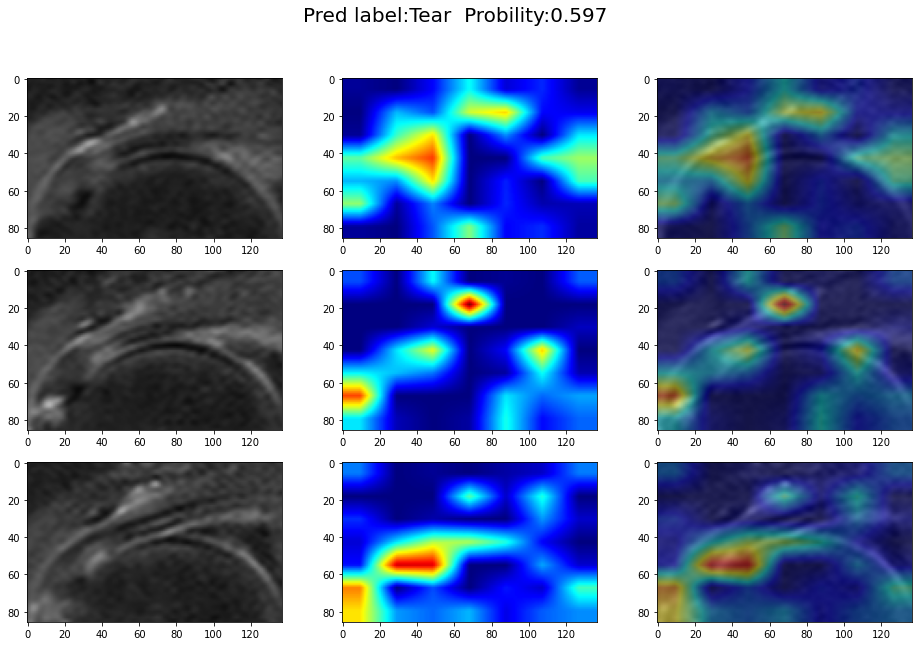

In [8]:
model.eval()
target_layer = [model.layers[-1].blocks[-1].norm1]
cam = GradCAM(model=model, target_layers=target_layer, use_cuda=True, reshape_transform=reshape_transform)

Transform_cam = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        ])

Save_folder_path= r"results\top_three_slices"
Image_paths = os.listdir(Save_basename)

plt.figure(figsize=(16, 10))
i = 0
for Image_path in Image_paths:
    ImageFullPath = os.path.join(Save_basename,Image_path)
    ImageFullName = os.path.basename(Image_path)
    ImageBasicName = ImageFullName.split('.')[0]
    imagePath = os.path.join(Save_basename,Image_path)

    CamImageName = ImageBasicName+'_cam.png'
    CamImagePath = os.path.join(Save_folder_path,CamImageName)

    MergedImageName = ImageBasicName+'_merged.png'
    MergedImagePath = os.path.join(Save_folder_path,MergedImageName)
    target_category = int(pred_label)

    rgb_img = Image.open(ImageFullPath)
    rgb_img_2 = Transform_cam(rgb_img).unsqueeze(0)
    rgb_img_1 = np.array(rgb_img ,dtype=np.float32)/255
    input_tensor = rgb_img_2.to('cuda')
    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category,aug_smooth=True)
    grayscale_cam = grayscale_cam[0]
    visualization = cv2.applyColorMap(np.uint8(255 * grayscale_cam),cv2.COLORMAP_JET)  # (224, 224, 3)

    img1=cv2.imread(ImageFullPath)
    h,w,_ = img1.shape
    img2 = cv2.resize(visualization, (w, h))
    dst=cv2.addWeighted(img1,0.6,img2,0.4,1) 
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img1,cmap="gray")
    plt.subplot(3, 3, i+2)
    plt.imshow(img2[:,:, ::-1])
    plt.subplot(3, 3, i+3)
    plt.imshow(dst[:,:, ::-1])
    i += 3
plt.suptitle(f'Pred label:{classifiction_reslut}  Probility:{probility_score}',fontsize=20)

